In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import mfmodel as mfm
import numba as nb

from scipy.sparse import coo_matrix
from scipy.linalg import block_diag, pinvh

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# np.random.seed(1001)
# random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 1000
signal_to_noise = 4


nsamples = 20
L = 5


ranks = np.array([10, 7, 5, 4, 1])
rank = ranks.sum()

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, 17, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], -4)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)
mfm.valid_hpart(hpart)

level=0, num_groups=1, mean_size=1000.0
level=1, num_groups=3, mean_size=333.3
level=2, num_groups=7, mean_size=142.9
level=3, num_groups=16, mean_size=62.5
level=4, num_groups=1000, mean_size=1.0


In [5]:
hpart['rows']['lk'][:-1]

[array([   0, 1000]),
 array([   0,  250,  500, 1000]),
 array([   0,  125,  250,  375,  500,  750,  875, 1000]),
 array([   0,   62,  125,  187,  250,  312,  375,  437,  500,  562,  625,
         687,  750,  812,  875,  937, 1000])]

In [6]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise, debug=True)
true_compressed_F = true_mlr.B[:, :-1]

signal_var=25.62634418177382, noise_var=6.372398593130684
SNR=4.021459707400993, signal_to_noise=4


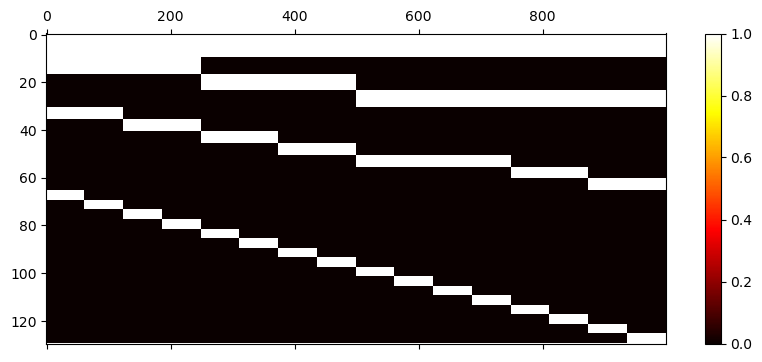

(1000, 130)


In [7]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T!=0, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [8]:
type(true_sparse_F)

numpy.ndarray

In [9]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [10]:
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)

num_levels=5, num_sparsities=16
(16, 4) [ 0  2  6 15]


In [11]:
F_Lm1, D = true_compressed_F+0, true_D_noise+0
pi = F_hpart['pi']
F_hpart['pi_inv'] = mf.inv_permutation(pi, pi)[0]
v = np.random.randn(n)

In [12]:
true_mlr.construct_sparse_format()
hat_x = mfm.iterative_refinement(ranks, v[:, np.newaxis], F_Lm1, D, F_hpart, eps=1e-12, max_iter=50)
np.linalg.norm(hat_x - np.linalg.inv(true_mlr.matrix()) @ v[:, np.newaxis])

3.025211020942249e-13

In [13]:
mfm_Sigma = mfm.MFModel(F=F_Lm1, D=D, hpart=F_hpart, ranks=ranks)

assert true_sparse_F.shape[1] == mfm_Sigma.num_factors()

# Linear system solve, matvec

In [14]:
for _ in range(10):
    v = np.random.randn(n, 1)
    # linear system solve
    hat_x = mfm_Sigma.solve(v, eps=1e-12, max_iter=50)
    reldiff = np.linalg.norm(hat_x - np.linalg.solve(true_mlr.matrix(),v)) / np.linalg.norm(v)
    print(f"solve {reldiff=}")
    assert reldiff < 1e-9

    # matvec
    Av = mfm_Sigma.matvec(v)
    reldiff = np.linalg.norm(Av - true_mlr.matvec(v)) / np.linalg.norm(v)
    assert reldiff < 1e-9, print(f"matvec {reldiff=}")


print("PASSED")

solve reldiff=6.2310318940790974e-15
solve reldiff=6.9826168024791094e-15
solve reldiff=6.4649432780609435e-15
solve reldiff=6.911259173011528e-15
solve reldiff=6.413068970320047e-15
solve reldiff=8.531794542609484e-15
solve reldiff=6.067804273741672e-15
solve reldiff=7.142426234143123e-15
solve reldiff=7.782320934823927e-15
solve reldiff=2.1085917451647602e-14
PASSED


# Test $\mathop{diag}(\Sigma)$

In [15]:
d1 = np.diag(true_mlr.matrix())
d2 = mfm_Sigma.diag()
assert np.allclose(d1, d2)

print("PASSED")

PASSED


# Test $\Sigma$

In [16]:
assert np.allclose(true_mlr.matrix(), mfm_Sigma.matrix())

print("PASSED")

PASSED


# EM elements

In [17]:
num_sparsities = row_selectors.size - 1
tilde_F0 = mf.convert_compressed_to_sparse(F_Lm1, F_hpart, ranks[:-1])
D1 = np.zeros(n)
# for si in tqdm(range(num_sparsities)):
for si in range(num_sparsities):
    si_col = mfm.group_to_indices(si_groups[si], part_sizes, ranks)
    tilde_F_ci = true_sparse_F[:, si_col]
    assert np.allclose(tilde_F_ci, mfm.get_sparse_F_si_col_sparsity(F_Lm1, ranks, F_hpart, si_groups[si]))

print("PASSED")

PASSED


In [18]:
assert np.allclose(mfm.perm_hat_Sigma(F_Lm1, D, F_hpart, ranks), mfm.perm_hat_Sigma_sp(true_sparse_F, D))
print("PASSED")

PASSED


In [19]:
C = mfm.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)

Z = (C - C.mean(axis=1, keepdims=True))[F_hpart["pi"], :]
unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mlr.pi_inv_rows, :][:, true_mlr.pi_inv_cols]

# permute to put clusters on diagonal
Y = Z.T
N = Y.shape[0]

In [20]:
mfm_Sigma.init_FD(ranks, F_hpart, Y=Y)
F0, D0 = mfm_Sigma.F, mfm_Sigma.D


unpermuted_F_hpart = {"pi_inv":np.arange(n), "pi":np.arange(n), "lk":F_hpart["lk"]}

In [21]:
loglikelihoods = [-np.inf]
N = Y.shape[0]
eps = 1e-12
for t in range(20):
    obj1 = mfm.fast_loglikelihood_value(F0, D0, Y, ranks, unpermuted_F_hpart)

    Sigma0 = mfm.perm_hat_Sigma(F0, D0, unpermuted_F_hpart, ranks)
    lu, piv = scipy.linalg.lu_factor(Sigma0)
    obj2 = mfm.loglikelihood_value(Sigma0, lu, piv, Y)
    # assert np.allclose(obj1, obj2), print(obj1, obj2)
    
    loglikelihoods += [obj1]
    if t % 5 == 0:
        print(f"{t=}, {obj1=}")

    F1 = mfm.fast_EM_get_F(F0, D0, Y, ranks, unpermuted_F_hpart, row_selectors, si_groups)
    F1_slow = mfm.EM_get_F(F0, lu, piv, Y, ranks, part_sizes, unpermuted_F_hpart, row_selectors, si_groups)
    assert mf.rel_diff(F1, F1_slow) < 1e-6, print(mf.rel_diff(F1, F1_slow))
    D1 = mfm.fast_EM_get_D(F0, D0, F1, Y, ranks, unpermuted_F_hpart, row_selectors, si_groups)
    D1_slow = mfm.EM_get_D(F0, F1, lu, piv, Y, ranks, part_sizes, unpermuted_F_hpart, row_selectors, si_groups)
    assert mf.rel_diff(D1, D1_slow) < 1e-5, print(mf.rel_diff(D1, D1_slow))
    F0, D0 = F1, D1
    assert D1.min() >= -1e-8 and loglikelihoods[-2] - 1e-8 <= loglikelihoods[-1]
    if loglikelihoods[-1] - loglikelihoods[-2] < eps * abs(loglikelihoods[-2]):
        print(f"terminating at {t=}")
        break
print(f"{t=}, {obj1=}")

print("PASSED")

t=0, obj1=-2405.668150698288
t=5, obj1=3396.3765063899073
7.875727084509036


AssertionError: None

In [ ]:
def fast_EM_intermediate_matrices(F0, D0, F_hpart, Y, ranks, si, si_groups, row_selectors):
    r1, r2 = row_selectors[si: si+2]
    N, n = Y.shape
    tilde_F_ci = mfm.get_sparse_F_si_col_sparsity(F0, ranks, F_hpart, si_groups[si]) # n x (r-1)
    assert tilde_F_ci.shape == (n, ranks[:-1].sum())
    Sigma0_inv_F_ci = np.zeros(tilde_F_ci.shape)
    Sigma0 = mfm.perm_hat_Sigma(F0, D0, F_hpart, ranks)
    for j in range(tilde_F_ci.shape[1]):
        Sigma0_inv_F_ci[:, j:j+1] = mfm.iterative_refinement(ranks, tilde_F_ci[:, j:j+1], F0, D0, F_hpart, 
                                                         eps=1e-16, max_iter=10, printing=False)
        # print(f"{mf.rel_diff(Sigma0_inv_F_ci[:, j:j+1], np.linalg.solve(Sigma0, tilde_F_ci[:, j:j+1]))}, {j=}, {si=}")
    # Sigma0_inv_F_ci2 = scipy.linalg.lu_solve((lu, piv), tilde_F_ci)
    Sigma0_inv_F_ci2 = np.linalg.solve(Sigma0, tilde_F_ci)
    print(f"{mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=}")
    F_ciT_Sigma0_inv_F_ci = tilde_F_ci.T @ Sigma0_inv_F_ci # (r-1) x (r-1)
    del tilde_F_ci
    Y_Sigma0_inv_F_ci = Y @ Sigma0_inv_F_ci # N x (r-1)
    ci_B_ci = N * (np.eye(ranks[:-1].sum()) - F_ciT_Sigma0_inv_F_ci) + Y_Sigma0_inv_F_ci.T @ Y_Sigma0_inv_F_ci
    del F_ciT_Sigma0_inv_F_ci
    ri_At_ci_t = Y_Sigma0_inv_F_ci.T @ Y[:, r1:r2] # (r-1) x (r2-r1)
    return ri_At_ci_t, ci_B_ci, r1, r2


def fast_EM_get_F(F0, D0, Y, ranks, F_hpart, row_selectors, si_groups):
    """
        Y: N x n has already permuted columns, ie, features ordered wrt F_hpart
    """
    F1 = np.zeros(F0.shape)
    num_sparsities = row_selectors.size - 1
    # for si in tqdm(range(num_sparsities)):
    for si in range(num_sparsities):
        ri_At_ci_t, ci_B_ci, r1, r2 = fast_EM_intermediate_matrices(F0, D0, F_hpart, Y, ranks, si, si_groups, row_selectors)
        F1[r1:r2, :] = np.linalg.solve(ci_B_ci, ri_At_ci_t).T
    return F1

In [ ]:
F1 = fast_EM_get_F(F0, D0, Y, ranks, unpermuted_F_hpart, row_selectors, si_groups)
F1_slow = mfm.EM_get_F(F0, lu, piv, Y, ranks, part_sizes, unpermuted_F_hpart, row_selectors, si_groups)
assert mf.rel_diff(F1, F1_slow) < 1e-6, print(mf.rel_diff(F1, F1_slow))

mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=2.0507513839868657e-06
mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=1.6113653272948848e-06
mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=1.6328949009463312e-06
mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=1.2794093269449418e-06
mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=2.1631064077834383e-06
mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=2.9340505461752337e-06
mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=2.942905152933249e-06
mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=3.10720769908055e-06
mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=4.894791840459332e-06
mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=3.795391350790543e-06
mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=1.3113442523796366e-05
mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=9.889433139579946e-06
mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=1.8621440850168181e-06
mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=1.677143284520618e-06
mf.rel_diff(Sigma0_inv_F_ci

AssertionError: None

In [ ]:
tilde_F_ci = mfm.get_sparse_F_si_col_sparsity(F_Lm1, ranks, F_hpart, si_groups[15])
plt.figure(figsize=(10, 4)) 
plt.matshow(tilde_F_ci!=0, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()

In [ ]:
tilde_F_ci = mfm.get_sparse_F_si_col_sparsity(F_Lm1, ranks, unpermuted_F_hpart, si_groups[si]) # n x (r-1)
assert tilde_F_ci.shape == (n, ranks[:-1].sum())
Sigma0_inv_F_ci = np.zeros(tilde_F_ci.shape)
Sigma0 = mfm.perm_hat_Sigma(F_Lm1, D, unpermuted_F_hpart, ranks)
for j in range(tilde_F_ci.shape[1]):
    Sigma0_inv_F_ci[:, j:j+1] = mfm.iterative_refinement(ranks, tilde_F_ci[:, j:j+1], F_Lm1, D, unpermuted_F_hpart, 
                                                        eps=1e-16, max_iter=10, printing=False)
    print(f"{mf.rel_diff(Sigma0_inv_F_ci[:, j:j+1], np.linalg.solve(Sigma0, tilde_F_ci[:, j:j+1]))}, {j=}, {si=}")
# Sigma0_inv_F_ci2 = scipy.linalg.lu_solve((lu, piv), tilde_F_ci)
Sigma0_inv_F_ci2 = np.linalg.solve(Sigma0, tilde_F_ci)
print(f"{mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=}")

6.653757262471368e-14, j=0, si=1
9.40274644002018e-14, j=1, si=1
6.8178533740139e-14, j=2, si=1
6.562517907425999e-14, j=3, si=1
9.877483826243786e-14, j=4, si=1
8.540197671362215e-14, j=5, si=1
7.209383087196164e-14, j=6, si=1
7.294676682807693e-14, j=7, si=1
6.383696257811487e-14, j=8, si=1
7.509564894529455e-14, j=9, si=1
1.8571923746407675e-14, j=10, si=1
2.1010312655788443e-14, j=11, si=1
2.3638913905095758e-14, j=12, si=1
2.1440758162694342e-14, j=13, si=1
2.1476662311235817e-14, j=14, si=1
2.678543864440726e-14, j=15, si=1
1.8163834186313752e-14, j=16, si=1
1.595353239244524e-14, j=17, si=1
1.5137443302696294e-14, j=18, si=1
1.602901746709767e-14, j=19, si=1
2.1510783260736902e-14, j=20, si=1
1.6566510961570615e-14, j=21, si=1
2.1650695810117686e-14, j=22, si=1
1.4634093992432853e-14, j=23, si=1
1.3439618379768307e-14, j=24, si=1
1.2101396213600405e-14, j=25, si=1
mf.rel_diff(Sigma0_inv_F_ci2, Sigma0_inv_F_ci)=4.961150868113376e-14


# Test $\mathop{diag}(\Sigma)$

In [ ]:
d1 = np.diag(true_mlr.matrix())
d2 = mfm_Sigma.diag()
assert np.allclose(d1, d2)

print("PASSED")

In [ ]:
mf.rel_diff(F1, F1_slow)